In [1]:
%%time
import manager_dataset as MD
import question_processing as QP
import information_retrieval as IR
import named_entity_recognition as NER
import answer_processing as AP
from gensim.models import KeyedVectors
from util import util

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Wall time: 32.4 s


### Settings

Questions recive all the questions treated

In [2]:
questions = MD.questions(treated=True)
incosiderate_classes = ['X', 'MANNER', 'OBJECT', 'OTHER', 'DEFINITION']
questions = QP.remove_incosiderate_classes(questions, incosiderate_classes)  # Question with incosiderate class is removed

The questions that has an answer will be used for test while another questions will be used for train.

In [3]:
train_questions, test_questions = MD.split_questions(questions)

## Question Processing

### Question Classification

Questions to train and test

In [4]:
qc_X_train, qc_y_train = QP.separete_questions(train_questions)

Or Load the Word2Vec model

In [ ]:
%%time
w2v_patch = 'data/word_embedding/cbow_s300.txt'
#w2v_patch = 'data/word_embedding/cbow_s50.txt'  # Fast test
w2v = KeyedVectors.load_word2vec_format(w2v_patch, unicode_errors="ignore")
model_w2v = {w: vec for w, vec in zip(w2v.index2word, w2v.syn0)}

And Train a SVM model

In [ ]:
%%time
classifier = QP.svm_classifier()
vectorizer = QP.HybridVectorizer(model_w2v)
#vectorizer = QP.MeanEmbeddingVectorizer(model_w2v)
#vectorizer = QP.TfidfHybridVectorizer(model_w2v)
#vectorizer = QP.SequenceHybridVectorizer(model_w2v)
#vectorizer = QP.count_vectorizer(model_w2v)
#vectorizer = QP.tfidf_vectorizer(model_w2v)
model = QP.train_model(qc_X_train, qc_y_train, classifier, vectorizer)

Or Loading the the trained SVM model

In [5]:
%%time
import dill
model = dill.load(open(QP.answer_type_file, 'rb'))

Wall time: 15.6 s


Answer type is predicted for all questions

In [6]:
questions = QP.predict_answer_type(model, test_questions)

#### Testing

In [7]:
qc_X_test, qc_y_test = QP.separete_questions(test_questions)
print('Size train:',len(qc_y_train),'  Size test:',len(qc_y_test))

Size train: 1694   Size test: 655


Accuracy: 0.906870229008
F1 Score: 0.900186476829


<IPython.core.display.Javascript object>


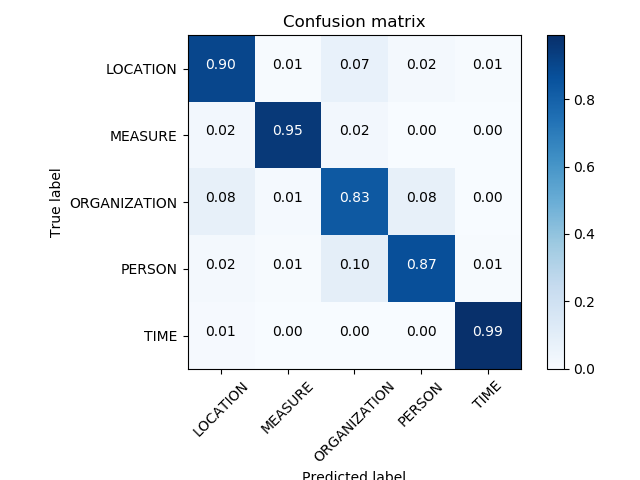

In [12]:
%matplotlib notebook
confusion_matrix = QP.testing(model, qc_X_test, qc_y_test)
QP.plot_confusion_matrix(confusion_matrix, ['LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON', 'TIME'], normalize=True)

### Query Formulation

All test questions will recive the query for IR module. 

In [9]:
test_questions = QP.queryFormulation(test_questions)

## Information Retrieval

### Document Retrieval

In [24]:
import information_retrieval as IR
ir = IR.InformationRetrieval()

Start the IR module. If the documents was not indexed then they will be.
When reset is True, all indexed documents is removed and indexed again.

In [28]:
ir.start(reset=False)

Indexing:
File: 51511 lines: 
51511/51510
File: 51674 lines: 
51674/51673
File: 51389 lines: 
51389/51388
File: 54708 lines: 
54708/54707
End


In [38]:
%%time
test_questions = ir.retrievalDocuments(test_questions)

Wall time: 3.3 s


#### Testing

In [39]:
import numpy as np

precisions = []
recalls = []
f_scores = []
b = 0.5
for question in test_questions:
    relevants = []
    for answer in question['answers']:
        if answer['doc'] is not None and len(answer['doc']) > 0:
            relevants.append(answer['doc'])
    total_relevants = len(relevants)
    if total_relevants == 0:
        continue
    relevents_retrieval = 0
    for retrieval in question['retrieval']:
        if retrieval in relevants:
            relevents_retrieval += 1
    if len(question['retrieval']) == 0:
           # print(question['query'])
            precision = 0
    else:
        precision = relevents_retrieval / len(question['retrieval'])
    precisions.append(precision)
    recall = relevents_retrieval / total_relevants
    recalls.append(recall)
    if (precision + recall) == 0:
        f_score = 0
    else:
        f_score = 2 * ((precision * recall) / (precision + recall))
    f_scores.append(f_score)

print('Precision: '+str(np.mean(precisions)))
print('Recall: '+str(np.mean(recalls)))
print('F-Score: '+str(np.mean(f_scores)))

Precision: 0.060141509434
Recall: 0.492391060198
F-Score: 0.104694452329


In [ ]:
test_questions[0]

In [37]:
test_questions[0]['retrieval']

['PUBLICO-19940328-046', 'FSP940201-077', 'PUBLICO-19940724-039']

In [ ]:
test_questions[0]['answers']

## Answer Processing

### Named Entity Recognition

In [20]:
import named_entity_recognition as NER

model_ner = NER.train()

#### Testing

In [21]:
NER.predict(model_ner, u'A cidade de Porto Seguro')

[['O', 'O', 'O', 'LOCAL-B', 'LOCAL-I']]

### Answer Extraction

In [34]:
test_questions = AP.answer_candidates(test_questions, QP, ir, NER, model_ner)

[ . . . . . . . . . . ]


### Answer Extraction

In [35]:
test_questions = AP.finals_answer(test_questions)

655/0


KeyboardInterrupt: 

#### Testing

Check if the answer_candidates have the right answer

In [ ]:
AP.test_answer_candidates(test_questions)

## Final Evaluate

In [ ]:
for i in range(len(test_questions)):
    print(test_questions[i]['question'])
    print(test_questions[i]['final_answer'])
    for answer in test_questions[i]['answers']:
        if answer['answer'] is not None:
            print(answer['answer'].strip(), end=' | ')
    print('\n')

In [ ]:
total = len(test_questions)
right = 0

cc_total = 0  # Total of question with correct candidates
cc_right = 0

for question in test_questions:
    aux = False
    if question['correct_answers_candidates']:
        aux = True
        cc_total += 1
    for answer in question['answers']:
        if answer['answer'] is not None:
            a1 = answer['answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            a2 = question['final_answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            if a1 in a2 or a2 in a1:
                question['correct_final_answer'] = True
                right += 1
                if aux:
                    cc_right += 1
                break
print(str(total) + ' / ' + str(right))
print('Accuracy: '+ '%.3f' % ((right/total)*100)+' %')
print('\nCorrect answer candidates:\n' + str(cc_total) + ' / ' + str(cc_right))
print('Accuracy: '+ '%.3f' % ((cc_right/cc_total)*100)+' %')

## Util

### Detailed Question Analysis

In [ ]:
question = {
    'question': u'Quem é o presidente da França?',
    'class': 'PERSON'
}

#question = test_questions[4]

print('Question: ' + question['question'])

# Question Classification
QP.predict_answer_type(model, [question])
print('Answer Type: ' + question['predict_class'])

# Query Formulation
QP.queryFormulation([question])
print('Query: ' + question['query'])

# Document Retrieval
ir.retrievalDocuments([question])
print('Number of retrieval documents: ' + str(len(question['retrieval'])))

# Answers Candidates
AP.answer_candidates([question], QP, ir, NER, model_ner, loading=False)
print('Number of answer candidates: ' + str(len(question['answer_candidates'])))

# Final Answer
AP.finals_answer([question])
print('Answer: ' + question['final_answer'])

Show documents texts

In [ ]:
for doc_id in question['retrieval']:
    print('\n'+doc_id+'\n'+ir.documentText(doc_id))

Show answers candidates

In [ ]:
    for ac in question['answer_candidates']:
        print(ac['full_answer'])

Show most vote answer candidates

In [ ]:
import operator
votes = {}
for candidate in question['answer_candidates']:
    if candidate['full_answer'].lower() not in question['question'].lower():
        if candidate['full_answer'] not in votes:
            votes[candidate['full_answer']] = candidate['votes']
[(k, votes[k]) for k in sorted(votes, key=votes.get, reverse=True)]

### Others

In [ ]:
ir.stop()

In [36]:
import importlib
importlib.reload(IR)
#raise IpyExit

<module 'information_retrieval' from 'C:\\Users\\Eduardo\\UFRGS\\QA\\qa-chave\\information_retrieval.py'>